# In this notebook we will calibrate a linear model using the Bayesian Approach

Thanks to ChatGPT for helping in the creation and comments of the code!

Thanks to Pablo for correcting ChatGPT on the few mistakes it made and for writing more comments!

## Generating data


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


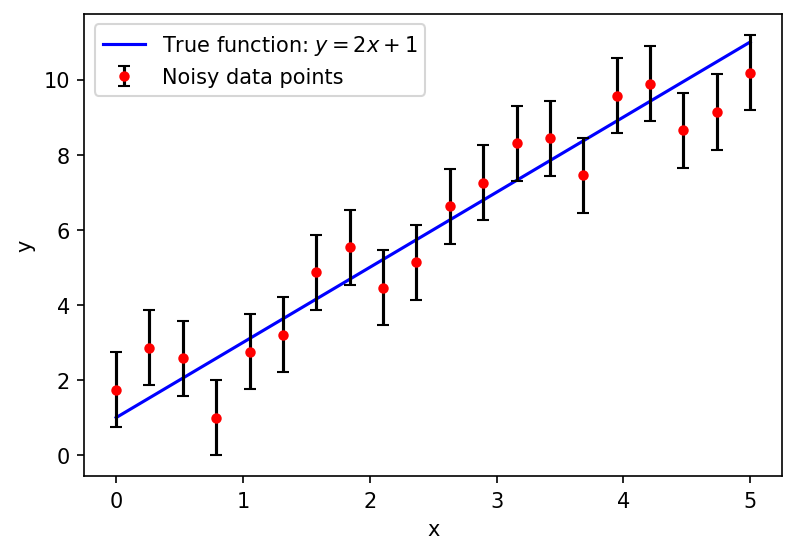

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
! pip install corner
import corner

# Set random seed for reproducibility
np.random.seed(142857)

# Generate 20 points normally distributed around a straight line y = 2x + 1
x = np.linspace(0, 5, 20)

# Noise level
noise_size = 1
noise = np.random.normal(0, noise_size, size=x.shape)

def true_f(x,a0=1,a1=2):
    return x*a1 + a0

def model_f(x,a0,a1):
    return x*a1 + a0
#Seems silly that we are basically defining the same function twice, but this way we can play with
# a different generating function for the true values later if we wanted to

y = true_f(x) + noise


# Generating function
y_true = true_f(x)

# Plot the points and the generating function
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(x, y_true, label='True function: $y = 2x + 1$', color='blue')
plt.errorbar(x, y, yerr=noise_size, fmt='o',markersize=4, color='red', label='Noisy data points', ecolor='black', elinewidth=1.5, capsize=3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# plt.grid(True)
plt.show()


## Bayesian calibration

Acceptance ratio (should be around 1/3): 0.38


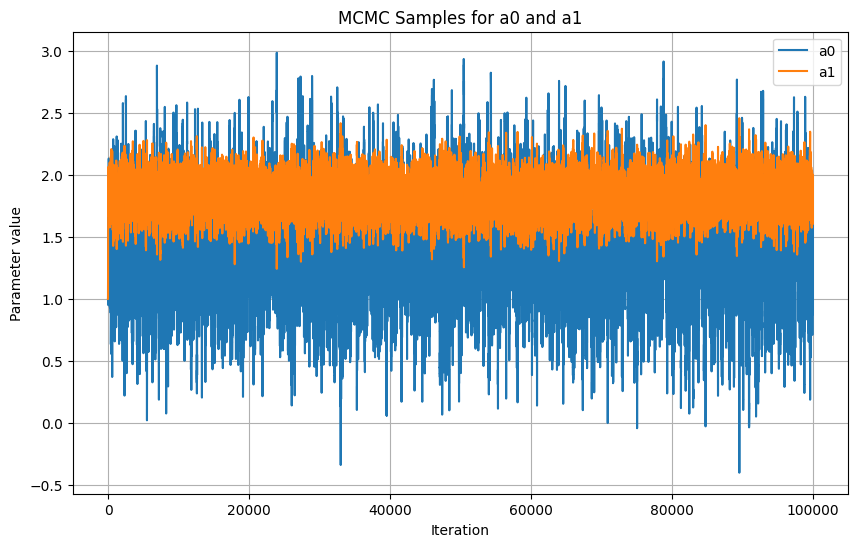

In [12]:
# Bayesian calibration using MCMC with Metropolis-Hastings algorithm

#Since likelihoods and priors usually look like exponentials (e^{stuff}), it is customary to work with their likelihoods.
#This makes it easier when handeling very tiny numbers, and they can be exponentiated later to build the posterior when doing the metrolopis algorithm


#Assuming a gaussian likelihood, what sits on top of it its what we usually call "chi2". We are also
# assuming that we know the error bars of the points perfectly well and that is "sigma", but if
# we didn't know it, there are ways of estimating it at the same time:

def log_likelihood(a0, a1, x, y, sigma=1):
    y_model = a0 + a1 * x
    return -0.5 * np.sum(((y - y_model) / sigma) ** 2)


#We have some prior knowledge of around where these things should be
a0_mu_prior= 1.0
a1_mu_prior= 2.0

#How sure are we about that? Bigger sigmas here mean we are less sure:
a0_sigma_prior= 2
a1_sigma_prior= 2

def log_prior(a0, a1):
    return - (0.5 + ((a1 - a1_mu_prior)/(a1_sigma_prior))**2.0 \
              + 0.5 + ((a0 - a0_mu_prior)/(a0_sigma_prior))**2.0)

def log_posterior(a0, a1, x, y, sigma=1):
    return log_prior(a0, a1) + log_likelihood(a0, a1, x, y, sigma)

# Initial guess
a0, a1 = 1, 1


n_iterations = 100000


#This step controlls how much we move in the parameter step on each MCMC iteration
step = 0.2

# Storage for samples
samples = np.zeros((n_iterations, 2))
samples[0, :] = [a0, a1]

# Count the number of acceptances
n_acceptances = 0

for i in range(1, n_iterations):
    a0_proposal = a0 + np.random.normal(0, step)
    a1_proposal = a1 + np.random.normal(0, step)
    
    log_posterior_current = log_posterior(a0, a1, x, y, sigma=1)
    
    log_posterior_proposal = log_posterior(a0_proposal, a1_proposal, x, y, sigma=1)
    
    acceptance_prob = np.exp(log_posterior_proposal - log_posterior_current)
    
    if np.random.rand() < acceptance_prob:
        # what do we do if the aceptance probability is bigger?
        a0, a1 = a0_proposal, a1_proposal
        n_acceptances += 1
    
    samples[i, :] = [a0, a1]

# Calculate and print the acceptance ratio
acceptance_ratio = n_acceptances / n_iterations
print(f'Acceptance ratio (should be around 1/3): {acceptance_ratio:.2f}')

# Plotting the samples
plt.figure(figsize=(10, 6))
plt.plot(samples[:, 0], label='a0')
plt.plot(samples[:, 1], label='a1')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()
plt.title('MCMC Samples for a0 and a1')
plt.grid(True)
plt.show()


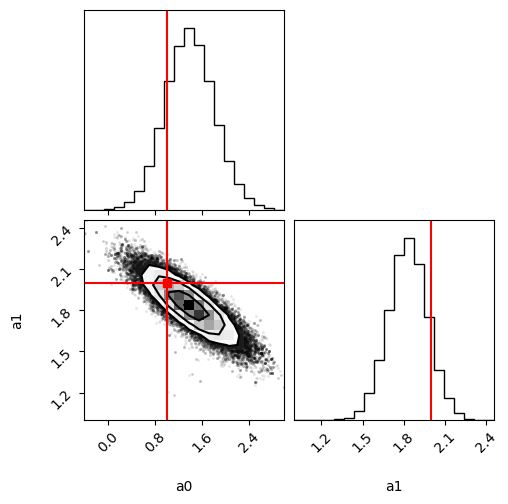

In [14]:

#This is a fake list of points just to show you how to plot them in the corner plot package. Replace by your own 
samples_fake= samples 


# Determine the limits for the corner plot
a0_min, a0_max = np.percentile(samples_fake[:, 0], [1, 99])*(0.4,1.2)
a1_min, a1_max = np.percentile(samples_fake[:, 1], [1, 99])*(0.9,1.1)

corner.corner(samples_fake, labels=["a0", "a1"], truths=[1, 2],truth_color='r', 
              # range=[(a0_min, a0_max), (a1_min, a1_max)], #Uncomment this line for the real case
              bins=20)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (100,) and (20,)

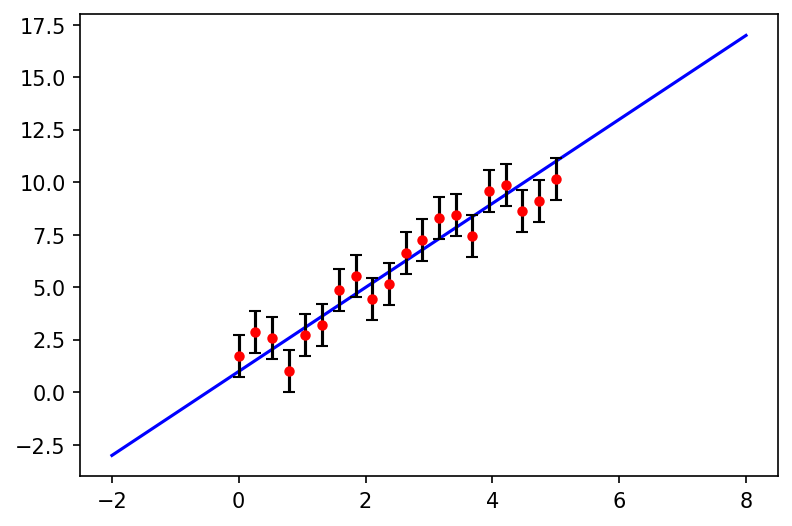

In [17]:
#Now we want to calculate the posterior distribution of the model lines themselves:


# Sampling 10,000 curves from the visited samples
n_samples = 10000
indices = np.random.choice(range(n_iterations), n_samples, replace=True)

sampled_a0 = samples[indices, 0]
sampled_a1 = samples[indices, 1]

x_extended = np.linspace(-2, 8, 100)
y_true_extended=true_f(x_extended)


# Generate y values for each sampled parameter set
y_samples = np.array([a0 + a1 * x for a0, a1 in zip(sampled_a0, sampled_a1)])


# Calculate mean and credible intervals for each x
y_mean = np.mean(y_samples, axis=0)
y_lower = np.percentile(y_samples, 2.5, axis=0)
y_upper = np.percentile(y_samples, 97.5, axis=0)

# Plotting the estimated mean model and credible intervals
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(x_extended, y_true_extended, label='True function: $y = 2x + 1$', color='blue')
plt.errorbar(x, y, yerr=noise_size, fmt='o',markersize=4, color='red', label='Noisy data points', ecolor='black', elinewidth=1.5, capsize=3)
plt.plot(x_extended, y_mean, label='Mean model', color='green')
plt.fill_between(x_extended, y_lower, y_upper, color='green', alpha=0.3, label='95% Credible interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# plt.grid(True)

plt.show()

